In [1]:
import pandas as pd
import numpy as np


# 讀取 mapping.csv 文件
mapping_df = pd.read_csv('/kaggle/input/drug-repositioning/mapping.csv')

# 提取疾病和藥物的唯一 ID
disease_ids = mapping_df['DiseaseID'].unique()
drug_ids = mapping_df['DrugID'].unique()

# 初始化疾病-藥物關係矩陣，所有值先設為 0
relationship_matrix = pd.DataFrame(0, index=disease_ids, columns=drug_ids)

# 根據 mapping.csv 設置有對應關係的值為 1
for row in mapping_df.itertuples(index=False):
    disease_id = row.DiseaseID
    drug_id = row.DrugID
    if disease_id in relationship_matrix.index and drug_id in relationship_matrix.columns:
        relationship_matrix.at[disease_id, drug_id] = 1

# 保存結果到 CSV 文件
output_file = 'disease_drug_relationship_matrix.csv'
relationship_matrix.to_csv(output_file, index=True)



# 確認生成結果
print("疾病-藥物關係矩陣已生成並保存為 'disease_drug_relationship_matrix.csv'")
print("矩陣大小: ", relationship_matrix.shape)
print(relationship_matrix.head())

疾病-藥物關係矩陣已生成並保存為 'disease_drug_relationship_matrix.csv'
矩陣大小:  (1573, 1410)
              DB09140  DB00730  DB00898  DB01168  DB00550  DB00668  DB00307  \
MESH:D000013        1        1        1        1        1        1        1   
MESH:D000014        1        0        1        0        0        0        0   
MESH:D000015        0        0        0        0        0        0        0   
MESH:D000022        0        0        0        0        0        0        0   
MESH:D000026        0        0        0        0        0        0        0   

              DB00313  DB01181  DB00347  ...  DB01349  DB00138  DB01201  \
MESH:D000013        1        1        1  ...        0        0        0   
MESH:D000014        1        0        1  ...        0        0        0   
MESH:D000015        1        0        1  ...        0        0        0   
MESH:D000022        0        0        0  ...        0        0        0   
MESH:D000026        0        0        0  ...        0        0        0   

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


# =============================
# 1. 讀取 disease_drug_relationship_matrix.csv
# =============================
relationship_matrix = pd.read_csv('/kaggle/working/disease_drug_relationship_matrix.csv', index_col=0)

# =============================
# 2. 計算疾病-疾病餘弦相似性矩陣
# =============================
# 疾病之間的相似性：基於行向量的餘弦相似性
disease_similarity = cosine_similarity(relationship_matrix.values)
disease_similarity_df = pd.DataFrame(disease_similarity, index=relationship_matrix.index, columns=relationship_matrix.index)

# 保存疾病-疾病餘弦相似性矩陣
disease_output_file = 'disease_cosine_similarity_matrix.csv'
disease_similarity_df.to_csv(disease_output_file)

# =============================
# 3. 計算藥物-藥物餘弦相似性矩陣
# =============================
# 藥物之間的相似性：基於列向量的餘弦相似性
drug_similarity = cosine_similarity(relationship_matrix.T.values)
drug_similarity_df = pd.DataFrame(drug_similarity, index=relationship_matrix.columns, columns=relationship_matrix.columns)

# 保存藥物-藥物餘弦相似性矩陣
drug_output_file = 'drug_cosine_similarity_matrix.csv'
drug_similarity_df.to_csv(drug_output_file)



# =============================
# 5. 確認輸出結果
# =============================
print("疾病-疾病餘弦相似性矩陣:")
print(disease_similarity_df.head())

print("\n藥物-藥物餘弦相似性矩陣:")
print(drug_similarity_df.head())

疾病-疾病餘弦相似性矩陣:
              MESH:D000013  MESH:D000014  MESH:D000015  MESH:D000022  \
MESH:D000013      1.000000      0.213980      0.301941      0.062017   
MESH:D000014      0.213980      1.000000      0.335968      0.138013   
MESH:D000015      0.301941      0.335968      1.000000      0.243432   
MESH:D000022      0.062017      0.138013      0.243432      1.000000   
MESH:D000026      0.000000      0.000000      0.000000      0.000000   

              MESH:D000026  MESH:D000037  MESH:D000067877  MESH:D000068079  \
MESH:D000013           0.0      0.000000         0.087706         0.130744   
MESH:D000014           0.0      0.188982         0.097590         0.072739   
MESH:D000015           0.0      0.222222         0.086066         0.064150   
MESH:D000022           0.0      0.182574         0.000000         0.000000   
MESH:D000026           1.0      0.000000         0.000000         0.000000   

              MESH:D000070642  MESH:D000072657  ...  MESH:D065630  \
MESH:D000013   

In [3]:
import pandas as pd
from itertools import combinations


# ==============================
# 1. 讀取文件
# ==============================
drugs_info = pd.read_csv('/kaggle/input/drug-repositioning/drugsInfo.csv')

# 確保 DrugID 和 DrugCategory 欄位存在
if 'DrugID' not in drugs_info.columns or 'DrugCategories' not in drugs_info.columns:
    raise ValueError("檔案必須包含 'DrugID' 和 'DrugCategory' 欄位")

# ==============================
# 2. 資料預處理
# ==============================
# 將 DrugCategory 解析為集合
drug_categories = drugs_info.set_index('DrugID')['DrugCategories'].apply(lambda x: set(x.split(',')))

# 獲取所有藥物的 ID
drug_ids = drug_categories.index.tolist()

# 初始化一個 DataFrame 來存儲 Jaccard 相似性
jaccard_matrix = pd.DataFrame(0.0, index=drug_ids, columns=drug_ids)

# ==============================
# 3. 計算 Jaccard 相似性
# ==============================
for drug1, drug2 in combinations(drug_ids, 2):
    set1 = drug_categories[drug1]
    set2 = drug_categories[drug2]

    # 計算交集和聯集
    intersection = len(set1 & set2)
    union = len(set1 | set2)

    # 計算 Jaccard 相似性
    jaccard_similarity = intersection / union if union != 0 else 0.0

    # 將結果填入矩陣 (對稱矩陣)
    jaccard_matrix.at[drug1, drug2] = jaccard_similarity
    jaccard_matrix.at[drug2, drug1] = jaccard_similarity

# 將對角線設為 1（每個藥物與自身的相似性為 1）
for drug_id in drug_ids:
    jaccard_matrix.at[drug_id, drug_id] = 1.0

# ==============================
# 4. 保存結果
# ==============================
output_file = 'drug_jaccard_similarity_matrix.csv'
jaccard_matrix.to_csv(output_file)



# ==============================
# 5. 輸出前幾行作確認
# ==============================
print("藥物-藥物 Jaccard 相似性矩陣:")
print(jaccard_matrix.head())

藥物-藥物 Jaccard 相似性矩陣:
          DB14509   DB00996   DB00740   DB01083   DB00759   DB00819   DB00162  \
DB14509  1.000000  0.107143  0.061224  0.022222  0.031746  0.056604  0.000000   
DB00996  0.107143  1.000000  0.083333  0.000000  0.031746  0.076923  0.028169   
DB00740  0.061224  0.083333  1.000000  0.000000  0.018519  0.121951  0.067797   
DB01083  0.022222  0.000000  0.000000  1.000000  0.020833  0.025641  0.000000   
DB00759  0.031746  0.031746  0.018519  0.020833  1.000000  0.204082  0.055556   

          DB00795   DB00982   DB01017  ...   DB00551   DB11581  DB01349  \
DB14509  0.017241  0.016667  0.000000  ...  0.026316  0.019231     0.00   
DB00996  0.000000  0.089286  0.041667  ...  0.000000  0.000000     0.00   
DB00740  0.020833  0.020000  0.000000  ...  0.000000  0.048780     0.00   
DB01083  0.000000  0.000000  0.000000  ...  0.045455  0.000000     0.00   
DB00759  0.033333  0.122807  0.358974  ...  0.024390  0.120000     0.05   

          DB01201   DB00576   DB09460   D

In [4]:
import pandas as pd
from itertools import combinations



# 讀取文件

diseases_info = pd.read_csv('/kaggle/input/drug-repositioning/diseasesInfo.csv')

# 確保必要的欄位存在
if 'DiseaseID' not in diseases_info.columns or 'SlimMapping' not in diseases_info.columns:
    raise ValueError("檔案必須包含 'DiseaseID' 和 'SlimMapping' 欄位")

# 處理 SlimMapping 欄位為集合
disease_mappings = diseases_info.set_index('DiseaseID')['SlimMapping'].apply(
    lambda x: set(x.split(',')) if pd.notna(x) else set()
)

# 獲取所有疾病的 ID
disease_ids = disease_mappings.index.tolist()

# 初始化 Jaccard 相似性矩陣
jaccard_matrix = pd.DataFrame(0.0, index=disease_ids, columns=disease_ids)

# 計算 Jaccard 相似性
for disease1, disease2 in combinations(disease_ids, 2):
    set1 = disease_mappings[disease1]
    set2 = disease_mappings[disease2]

    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard_similarity = intersection / union if union != 0 else 0.0

    jaccard_matrix.at[disease1, disease2] = jaccard_similarity
    jaccard_matrix.at[disease2, disease1] = jaccard_similarity

# 設置對角線為 1
for disease_id in disease_ids:
    jaccard_matrix.at[disease_id, disease_id] = 1.0

# 保存結果
output_file = 'disease_jaccard_similarity_matrix.csv'
jaccard_matrix.to_csv(output_file)
print(f"Jaccard 相似性矩陣已保存為: {output_file}")




Jaccard 相似性矩陣已保存為: disease_jaccard_similarity_matrix.csv


In [5]:
import pandas as pd

# 上傳檔案



# 讀取檔案
disease_similarity_matrix = pd.read_csv('/kaggle/working/disease_jaccard_similarity_matrix.csv', index_col=0)
drug_similarity_matrix = pd.read_csv('/kaggle/working/drug_jaccard_similarity_matrix.csv', index_col=0)
filtered_mapping_df = pd.read_csv('/kaggle/input/drug-repositioning/mapping.csv')

# 初始化正樣本關係向量列表
positive_relationship_vectors = []

# 遍歷過濾的疾病-藥物名單
for row in filtered_mapping_df.itertuples(index=False):
    disease_id = row.DiseaseID
    drug_id = row.DrugID

    # 如果疾病和藥物存在於相似性矩陣中
    if disease_id in disease_similarity_matrix.index and drug_id in drug_similarity_matrix.index:
        disease_row = disease_similarity_matrix.loc[disease_id].values.tolist()
        drug_row = drug_similarity_matrix.loc[drug_id].values.tolist()

        # 合併為關係向量並標記為正樣本
        relationship_vector = [disease_id, drug_id] + disease_row + drug_row + [1]  # 1 表示正樣本
        positive_relationship_vectors.append(relationship_vector)

# 定義列名
columns = ['DiseaseID', 'DrugID'] + \
          [f'DiseaseSim_{i+1}' for i in range(disease_similarity_matrix.shape[0])] + \
          [f'DrugSim_{i+1}' for i in range(drug_similarity_matrix.shape[0])] + \
          ['Label']  # Label 列表示正樣本

# 轉換為 DataFrame
positive_relationship_vectors_df = pd.DataFrame(positive_relationship_vectors, columns=columns)

# 保存正樣本至 CSV
positive_relationship_vectors_df.to_csv('jaccad_only_positive_relationship_vectors.csv', index=False)

In [6]:
import pandas as pd
import random



# 讀取檔案
disease_similarity_matrix = pd.read_csv('/kaggle/working/disease_jaccard_similarity_matrix.csv', index_col=0)
drug_similarity_matrix = pd.read_csv('/kaggle/working/drug_jaccard_similarity_matrix.csv', index_col=0)
filtered_mapping_df = pd.read_csv('/kaggle/input/drug-repositioning/mapping.csv')

# 提取所有疾病和藥物的ID
all_diseases = disease_similarity_matrix.index.tolist()
all_drugs = drug_similarity_matrix.index.tolist()

# 建立現有的疾病-藥物對集合
existing_pairs = set(zip(filtered_mapping_df['DiseaseID'], filtered_mapping_df['DrugID']))

# 生成隨機負樣本
negative_samples = []
while len(negative_samples) < 42200:
    random_disease = random.choice(all_diseases)
    random_drug = random.choice(all_drugs)
    if (random_disease, random_drug) not in existing_pairs:
        disease_row = disease_similarity_matrix.loc[random_disease].values.tolist()
        drug_row = drug_similarity_matrix.loc[random_drug].values.tolist()
        negative_samples.append([random_disease, random_drug] + disease_row + drug_row + [0])  # 0 表示負樣本

# 設定欄位名稱
columns = ['DiseaseID', 'DrugID'] + \
          [f'DiseaseSim_{i+1}' for i in range(disease_similarity_matrix.shape[0])] + \
          [f'DrugSim_{i+1}' for i in range(drug_similarity_matrix.shape[0])] + \
          ['Label']  # 標籤欄位

# 將負樣本轉為 DataFrame
negative_relationship_vectors_df = pd.DataFrame(negative_samples, columns=columns)

# 保存為 CSV 檔案
negative_relationship_vectors_df.to_csv('jaccad_only_negative_relationship_vectors.csv', index=False)

In [7]:
import pandas as pd


# 讀取檔案
disease_similarity_matrix = pd.read_csv('/kaggle/working/disease_cosine_similarity_matrix.csv', index_col=0)
drug_similarity_matrix = pd.read_csv('/kaggle/working/drug_cosine_similarity_matrix.csv', index_col=0)
filtered_mapping_df = pd.read_csv('/kaggle/input/drug-repositioning/mapping.csv')

# 初始化正樣本關係向量列表
positive_relationship_vectors = []

# 遍歷過濾的疾病-藥物名單
for row in filtered_mapping_df.itertuples(index=False):
    disease_id = row.DiseaseID
    drug_id = row.DrugID

    # 如果疾病和藥物存在於相似性矩陣中
    if disease_id in disease_similarity_matrix.index and drug_id in drug_similarity_matrix.index:
        disease_row = disease_similarity_matrix.loc[disease_id].values.tolist()
        drug_row = drug_similarity_matrix.loc[drug_id].values.tolist()

        # 合併為關係向量並標記為正樣本
        relationship_vector = [disease_id, drug_id] + disease_row + drug_row + [1]  # 1 表示正樣本
        positive_relationship_vectors.append(relationship_vector)

# 定義列名
columns = ['DiseaseID', 'DrugID'] + \
          [f'DiseaseSim_{i+1}' for i in range(disease_similarity_matrix.shape[0])] + \
          [f'DrugSim_{i+1}' for i in range(drug_similarity_matrix.shape[0])] + \
          ['Label']  # Label 列表示正樣本

# 轉換為 DataFrame
positive_relationship_vectors_df = pd.DataFrame(positive_relationship_vectors, columns=columns)

# 保存正樣本至 CSV
positive_relationship_vectors_df.to_csv('cosine_only_positive_relationship_vectors.csv', index=False)

In [8]:
import pandas as pd
import random



# 讀取檔案
disease_similarity_matrix = pd.read_csv('/kaggle/working/disease_cosine_similarity_matrix.csv', index_col=0)
drug_similarity_matrix = pd.read_csv('/kaggle/working/drug_cosine_similarity_matrix.csv', index_col=0)
filtered_mapping_df = pd.read_csv('/kaggle/input/drug-repositioning/mapping.csv')

# 提取所有疾病和藥物的ID
all_diseases = disease_similarity_matrix.index.tolist()
all_drugs = drug_similarity_matrix.index.tolist()

# 建立現有的疾病-藥物對集合
existing_pairs = set(zip(filtered_mapping_df['DiseaseID'], filtered_mapping_df['DrugID']))

# 生成隨機負樣本
negative_samples = []
while len(negative_samples) < 42200:
    random_disease = random.choice(all_diseases)
    random_drug = random.choice(all_drugs)
    if (random_disease, random_drug) not in existing_pairs:
        disease_row = disease_similarity_matrix.loc[random_disease].values.tolist()
        drug_row = drug_similarity_matrix.loc[random_drug].values.tolist()
        negative_samples.append([random_disease, random_drug] + disease_row + drug_row + [0])  # 0 表示負樣本

# 設定欄位名稱
columns = ['DiseaseID', 'DrugID'] + \
          [f'DiseaseSim_{i+1}' for i in range(disease_similarity_matrix.shape[0])] + \
          [f'DrugSim_{i+1}' for i in range(drug_similarity_matrix.shape[0])] + \
          ['Label']  # 標籤欄位

# 將負樣本轉為 DataFrame
negative_relationship_vectors_df = pd.DataFrame(negative_samples, columns=columns)

# 保存為 CSV 檔案
negative_relationship_vectors_df.to_csv('cosine_only_negative_relationship_vectors.csv', index=False)

Epoch 1/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 94s 346ms/step - loss: 0.9829 - val_loss: 0.8381
Epoch 2/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 95s 359ms/step - loss: 0.8350 - val_loss: 0.8260
Epoch 3/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 97s 366ms/step - loss: 0.8240 - val_loss: 0.8218
Epoch 4/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 95s 361ms/step - loss: 0.8214 - val_loss: 0.8201
Epoch 5/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 91s 344ms/step - loss: 0.8179 - val_loss: 0.8185
Epoch 6/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 141s 341ms/step - loss: 0.8178 - val_loss: 0.8173
Epoch 7/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 89s 338ms/step - loss: 0.8168 - val_loss: 0.8167
Epoch 8/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 145s 351ms/step - loss: 0.8126 - val_loss: 0.8162
Epoch 9/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 95s 361ms/step - loss: 0.8146 - val_loss: 0.8149
Epoch 10/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 93s 351ms/step - loss: 0.8151 - val_loss: 0.8137
Epoch 11/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 95s 359ms/step - loss: 0.8113 - val_loss: 0.8129
Epoch 12/25
264/2

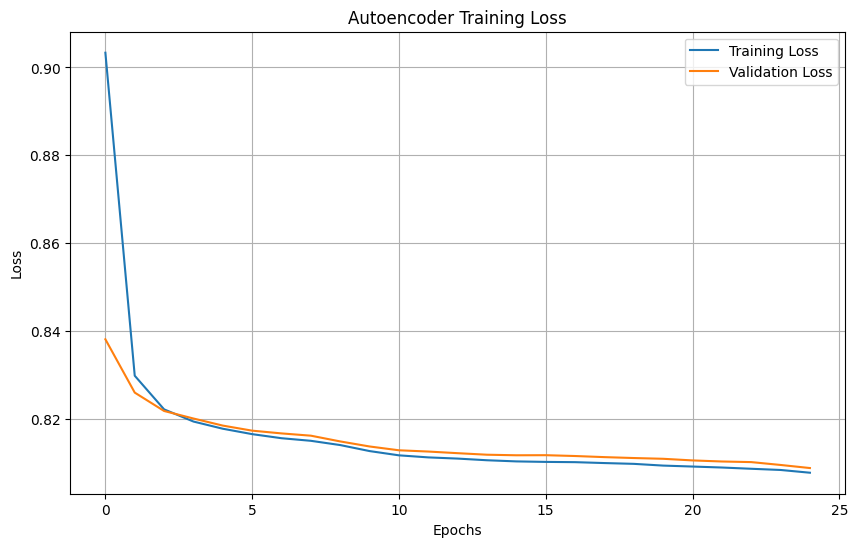

2110/2110 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


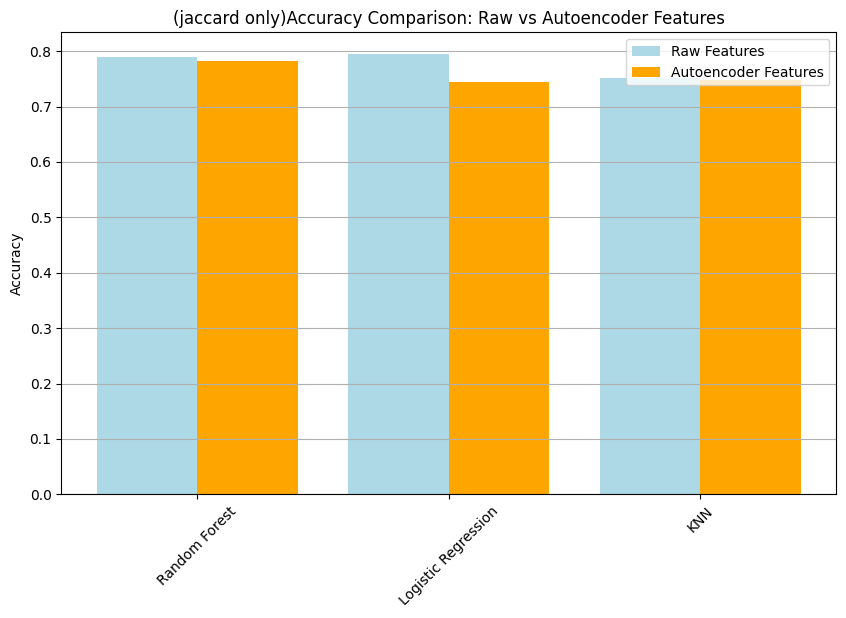

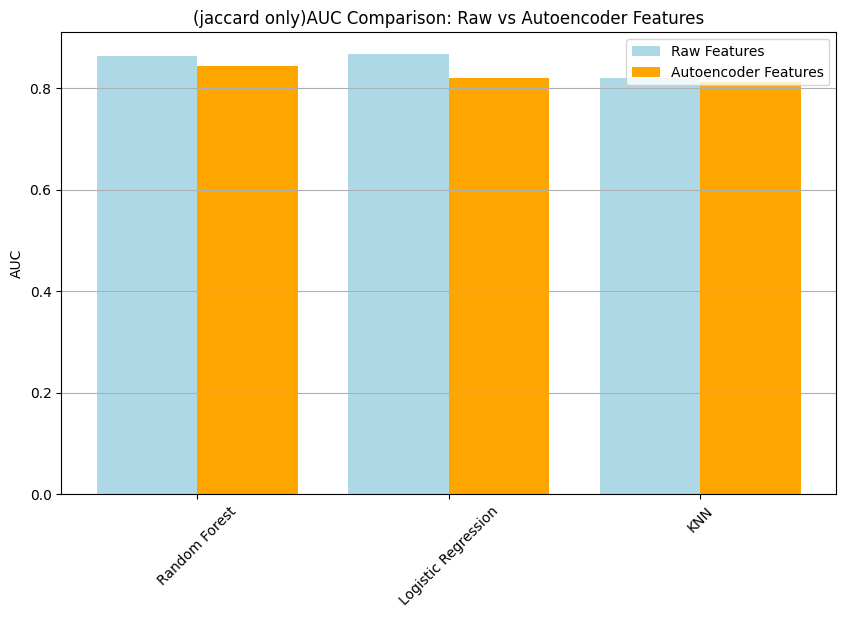

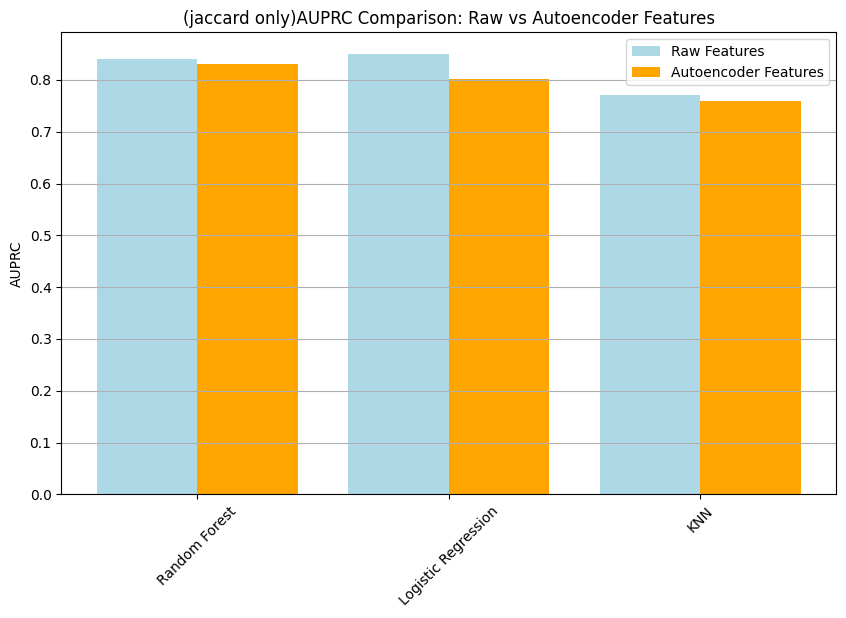

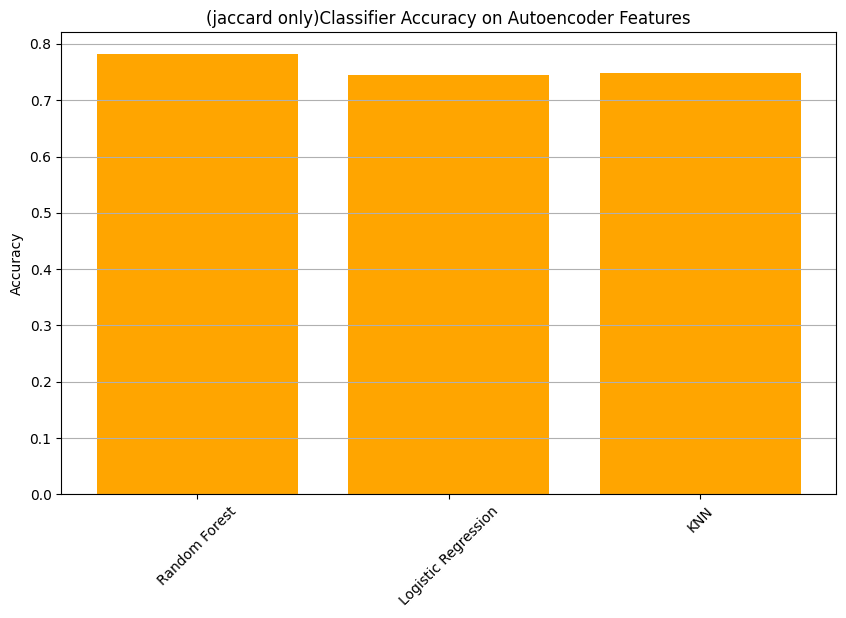

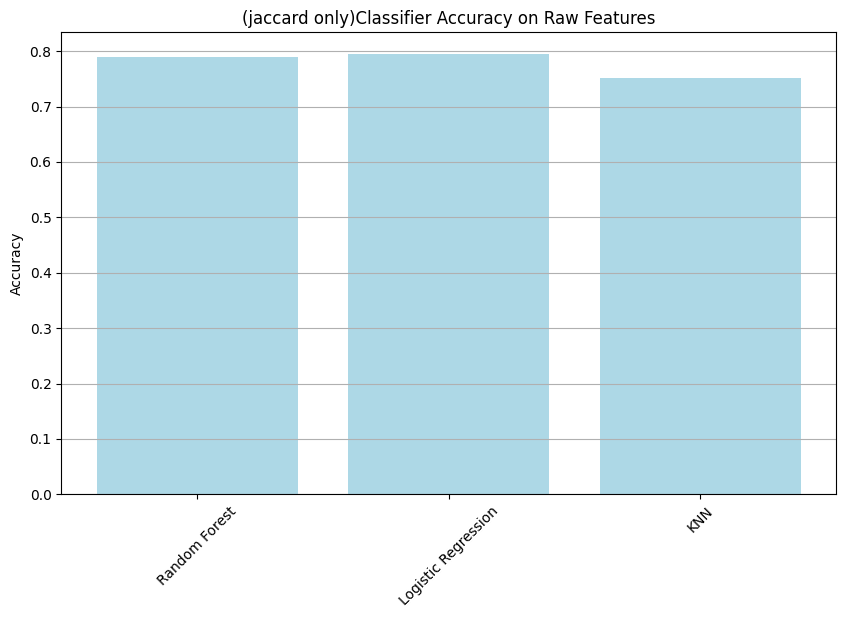

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# ==============================
# 讀取數據
# ==============================
positive_vectors = pd.read_csv('/kaggle/working/jaccad_only_positive_relationship_vectors.csv')
negative_vectors = pd.read_csv('/kaggle/working/jaccad_only_negative_relationship_vectors.csv')

# 合併數據並移除非數值列
all_vectors = pd.concat([positive_vectors, negative_vectors], ignore_index=True)
labels = all_vectors['Label']
features = all_vectors.drop(columns=['DiseaseID', 'DrugID', 'Label'])

# 填充異常值
features = features.fillna(0).replace([np.inf, -np.inf], 0)

# 正規化數據
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


# 設置 Autoencoder 結構
input_dim = X_train.shape[1]
encoding_dim = 512  # 壓縮到 512 維

# 編碼器結構
input_layer = Input(shape=(input_dim,))
encoder = Dense(2048, activation='relu')(input_layer)
encoder = Dense(1024, activation='relu')(encoder)  # 新增 1024 維層
encoder = Dense(encoding_dim, activation='relu')(encoder)

# 解碼器結構

decoder = Dense(1024, activation='relu')(encoder)
decoder = Dense(2048, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# 定義 Autoencoder 模型
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 定義僅包含編碼器的模型
encoder_model = Model(inputs=input_layer, outputs=encoder)

# 編譯模型
autoencoder.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='mse')

# 訓練 Autoencoder 並記錄損失
history = autoencoder.fit(
    X_train, X_train,
    epochs=25,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

# 繪製降維過程損失圖
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 降維後的特徵
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

# ==============================
# 定義分類器與評估函數
# ==============================
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
}

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0
    auprc = average_precision_score(y_test, y_proba) if y_proba is not None else 0
    return acc, auc, auprc

# 評估結果
results_autoencoder = {}
results_raw = {}
for name, clf in classifiers.items():
    # 評估未降維資料
    acc, auc, auprc = evaluate_model(clf, X_train, y_train, X_test, y_test)
    results_raw[name] = {"Accuracy": acc, "AUC": auc, "AUPRC": auprc}
    # 評估降維後資料
    acc, auc, auprc = evaluate_model(clf, X_train_encoded, y_train, X_test_encoded, y_test)
    results_autoencoder[name] = {"Accuracy": acc, "AUC": auc, "AUPRC": auprc}

# ==============================
# 繪製比較圖
# ==============================
def plot_comparison(metric, title):
    raw_scores = [results_raw[clf][metric] for clf in classifiers.keys()]
    autoencoder_scores = [results_autoencoder[clf][metric] for clf in classifiers.keys()]
    x = np.arange(len(classifiers))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, raw_scores, width=0.4, label='Raw Features', color='lightblue')
    plt.bar(x + 0.2, autoencoder_scores, width=0.4, label='Autoencoder Features', color='orange')
    plt.title(title)
    plt.ylabel(metric)
    plt.xticks(x, classifiers.keys(), rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# 繪製各類圖
plot_comparison("Accuracy", "(jaccard only)Accuracy Comparison: Raw vs Autoencoder Features")
plot_comparison("AUC", "(jaccard only)AUC Comparison: Raw vs Autoencoder Features")
plot_comparison("AUPRC", "(jaccard only)AUPRC Comparison: Raw vs Autoencoder Features")

# 各分類器在 Autoencoder 資料上的準確率比較圖
autoencoder_acc = [results_autoencoder[clf]["Accuracy"] for clf in classifiers.keys()]
plt.figure(figsize=(10, 6))
plt.bar(classifiers.keys(), autoencoder_acc, color='orange')
plt.title("(jaccard only)Classifier Accuracy on Autoencoder Features")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 各分類器在未降維資料的準確率比較圖
raw_acc = [results_raw[clf]["Accuracy"] for clf in classifiers.keys()]
plt.figure(figsize=(10, 6))
plt.bar(classifiers.keys(), raw_acc, color='lightblue')
plt.title("(jaccard only)Classifier Accuracy on Raw Features")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [10]:
# ==============================
# Print Autoencoder 和 Raw 特徵的結果
# ==============================

print("(jaccard only)Results for Raw Features:")
for name, metrics in results_raw.items():
    print(f"{name}:")
    print(f"    Accuracy: {metrics['Accuracy']:.4f}")
    print(f"    AUC: {metrics['AUC']:.4f}")
    print(f"    AUPRC: {metrics['AUPRC']:.4f}")

print("\n(jaccard only)Results for Autoencoder Features:")
for name, metrics in results_autoencoder.items():
    print(f"{name}:")
    print(f"    Accuracy: {metrics['Accuracy']:.4f}")
    print(f"    AUC: {metrics['AUC']:.4f}")
    print(f"    AUPRC: {metrics['AUPRC']:.4f}")


(jaccard only)Results for Raw Features:
Random Forest:
    Accuracy: 0.7890
    AUC: 0.8633
    AUPRC: 0.8405
Logistic Regression:
    Accuracy: 0.7942
    AUC: 0.8672
    AUPRC: 0.8494
KNN:
    Accuracy: 0.7507
    AUC: 0.8206
    AUPRC: 0.7715

(jaccard only)Results for Autoencoder Features:
Random Forest:
    Accuracy: 0.7815
    AUC: 0.8448
    AUPRC: 0.8304
Logistic Regression:
    Accuracy: 0.7448
    AUC: 0.8197
    AUPRC: 0.8013
KNN:
    Accuracy: 0.7479
    AUC: 0.8132
    AUPRC: 0.7586


Epoch 1/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 339ms/step - loss: 0.9254 - val_loss: 0.7183
Epoch 2/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 141s 334ms/step - loss: 0.6993 - val_loss: 0.6701
Epoch 3/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 95s 360ms/step - loss: 0.6617 - val_loss: 0.6494
Epoch 4/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 88s 332ms/step - loss: 0.6408 - val_loss: 0.6380
Epoch 5/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 92s 350ms/step - loss: 0.6337 - val_loss: 0.6304
Epoch 6/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 144s 359ms/step - loss: 0.6283 - val_loss: 0.6255
Epoch 7/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step - loss: 0.6219 - val_loss: 0.6215
Epoch 8/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.6178 - val_loss: 0.6187
Epoch 9/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 89s 337ms/step - loss: 0.6175 - val_loss: 0.6167
Epoch 10/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 89s 336ms/step - loss: 0.6142 - val_loss: 0.6146
Epoch 11/25
264/264 ━━━━━━━━━━━━━━━━━━━━ 88s 333ms/step - loss: 0.6086 - val_loss: 0.6127
Epoch 12/25
264/

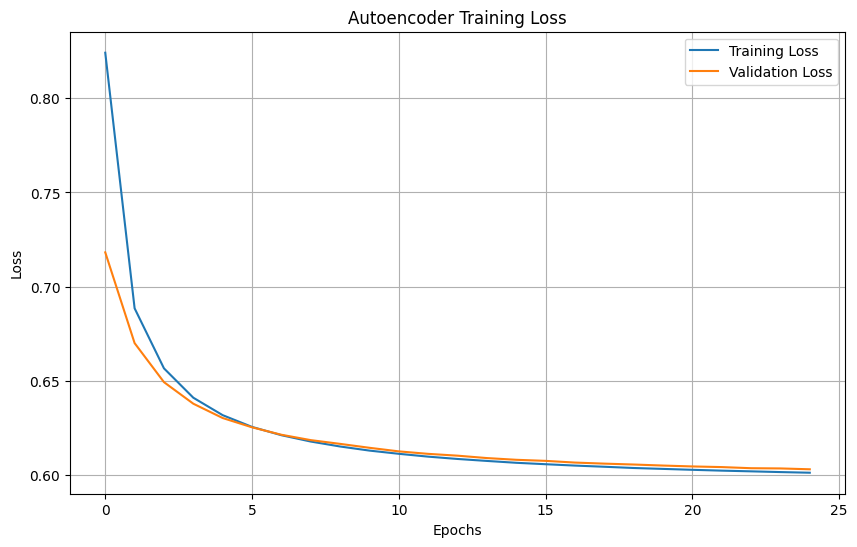

2110/2110 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


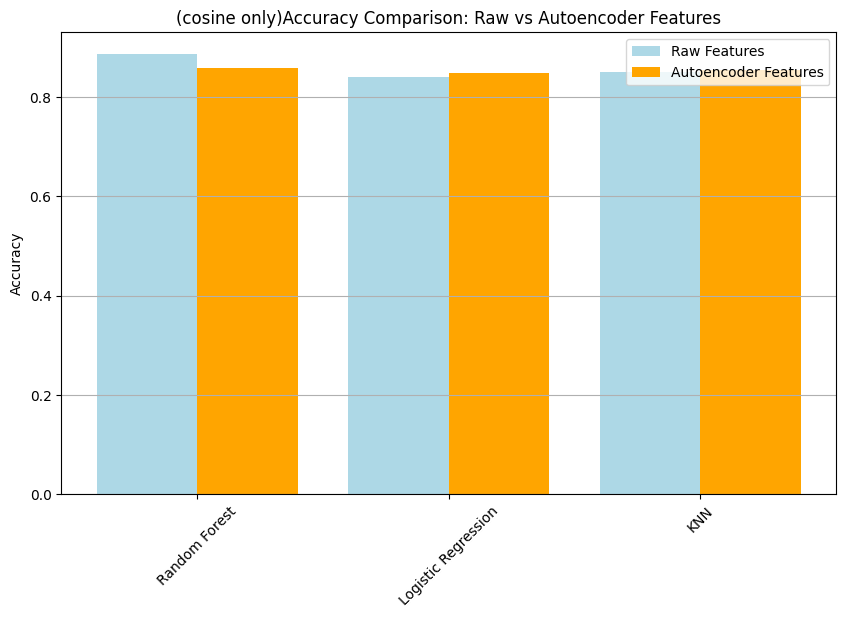

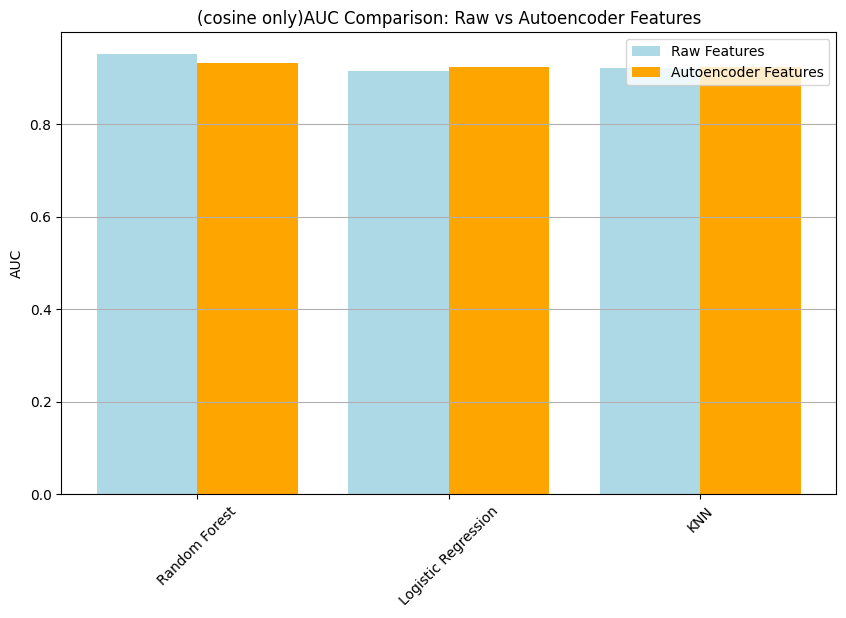

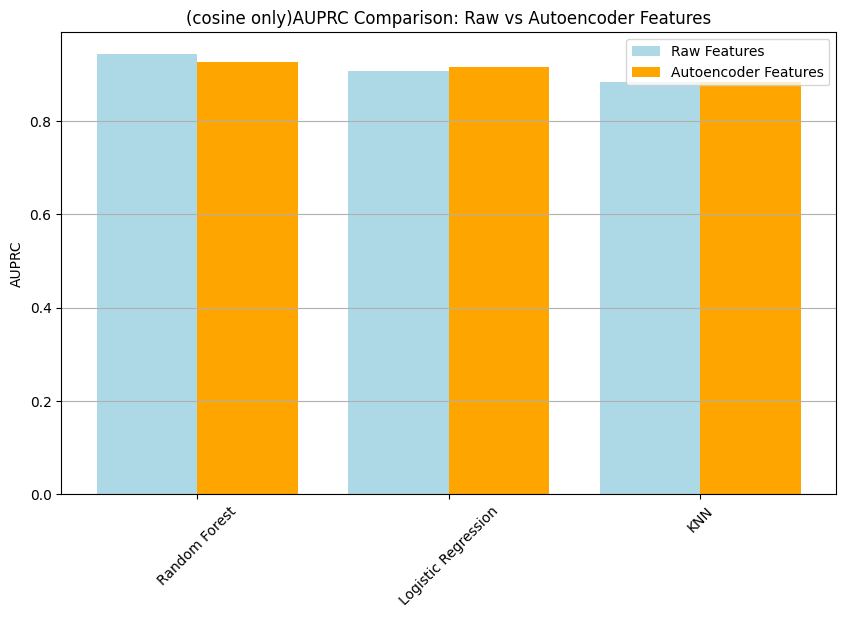

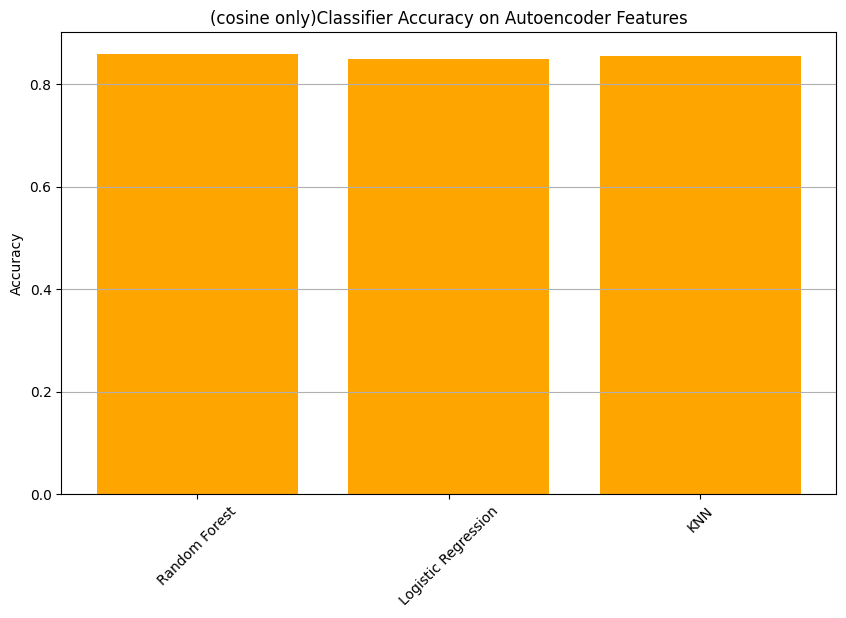

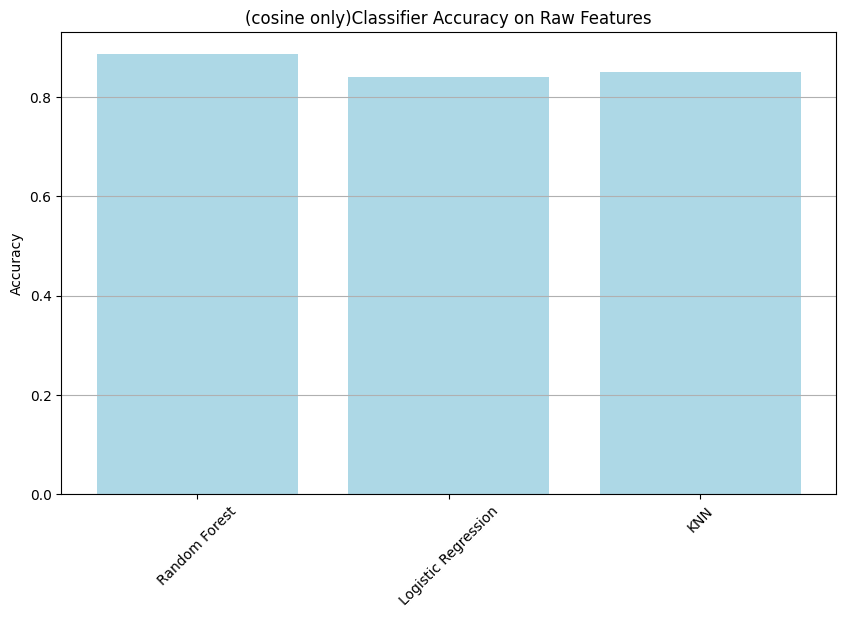

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# ==============================
# 讀取數據
# ==============================
positive_vectors = pd.read_csv('/kaggle/working/cosine_only_positive_relationship_vectors.csv')
negative_vectors = pd.read_csv('/kaggle/working/cosine_only_negative_relationship_vectors.csv')

# 合併數據並移除非數值列
all_vectors = pd.concat([positive_vectors, negative_vectors], ignore_index=True)
labels = all_vectors['Label']
features = all_vectors.drop(columns=['DiseaseID', 'DrugID', 'Label'])

# 填充異常值
features = features.fillna(0).replace([np.inf, -np.inf], 0)

# 正規化數據
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


# 設置 Autoencoder 結構
input_dim = X_train.shape[1]
encoding_dim = 512  # 壓縮到 512 維

# 編碼器結構
input_layer = Input(shape=(input_dim,))
encoder = Dense(2048, activation='relu')(input_layer)
encoder = Dense(1024, activation='relu')(encoder)  # 新增 1024 維層
encoder = Dense(encoding_dim, activation='relu')(encoder)

# 解碼器結構

decoder = Dense(1024, activation='relu')(encoder)
decoder = Dense(2048, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# 定義 Autoencoder 模型
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 定義僅包含編碼器的模型
encoder_model = Model(inputs=input_layer, outputs=encoder)

# 編譯模型
autoencoder.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='mse')

# 訓練 Autoencoder 並記錄損失
history = autoencoder.fit(
    X_train, X_train,
    epochs=25,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

# 繪製降維過程損失圖
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 降維後的特徵
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

# ==============================
# 定義分類器與評估函數
# ==============================
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
}

def evaluate_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0
    auprc = average_precision_score(y_test, y_proba) if y_proba is not None else 0
    return acc, auc, auprc

# 評估結果
results_autoencoder = {}
results_raw = {}
for name, clf in classifiers.items():
    # 評估未降維資料
    acc, auc, auprc = evaluate_model(clf, X_train, y_train, X_test, y_test)
    results_raw[name] = {"Accuracy": acc, "AUC": auc, "AUPRC": auprc}
    # 評估降維後資料
    acc, auc, auprc = evaluate_model(clf, X_train_encoded, y_train, X_test_encoded, y_test)
    results_autoencoder[name] = {"Accuracy": acc, "AUC": auc, "AUPRC": auprc}

# ==============================
# 繪製比較圖
# ==============================
def plot_comparison(metric, title):
    raw_scores = [results_raw[clf][metric] for clf in classifiers.keys()]
    autoencoder_scores = [results_autoencoder[clf][metric] for clf in classifiers.keys()]
    x = np.arange(len(classifiers))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, raw_scores, width=0.4, label='Raw Features', color='lightblue')
    plt.bar(x + 0.2, autoencoder_scores, width=0.4, label='Autoencoder Features', color='orange')
    plt.title(title)
    plt.ylabel(metric)
    plt.xticks(x, classifiers.keys(), rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# 繪製各類圖
plot_comparison("Accuracy", "(cosine only)Accuracy Comparison: Raw vs Autoencoder Features")
plot_comparison("AUC", "(cosine only)AUC Comparison: Raw vs Autoencoder Features")
plot_comparison("AUPRC", "(cosine only)AUPRC Comparison: Raw vs Autoencoder Features")

# 各分類器在 Autoencoder 資料上的準確率比較圖
autoencoder_acc = [results_autoencoder[clf]["Accuracy"] for clf in classifiers.keys()]
plt.figure(figsize=(10, 6))
plt.bar(classifiers.keys(), autoencoder_acc, color='orange')
plt.title("(cosine only)Classifier Accuracy on Autoencoder Features")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 各分類器在未降維資料的準確率比較圖
raw_acc = [results_raw[clf]["Accuracy"] for clf in classifiers.keys()]
plt.figure(figsize=(10, 6))
plt.bar(classifiers.keys(), raw_acc, color='lightblue')
plt.title("(cosine only)Classifier Accuracy on Raw Features")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [12]:
# ==============================
# Print Autoencoder 和 Raw 特徵的結果
# ==============================

print("(cosine only)Results for Raw Features:")
for name, metrics in results_raw.items():
    print(f"{name}:")
    print(f"    Accuracy: {metrics['Accuracy']:.4f}")
    print(f"    AUC: {metrics['AUC']:.4f}")
    print(f"    AUPRC: {metrics['AUPRC']:.4f}")

print("\n(cosine only)Results for Autoencoder Features:")
for name, metrics in results_autoencoder.items():
    print(f"{name}:")
    print(f"    Accuracy: {metrics['Accuracy']:.4f}")
    print(f"    AUC: {metrics['AUC']:.4f}")
    print(f"    AUPRC: {metrics['AUPRC']:.4f}")

(cosine only)Results for Raw Features:
Random Forest:
    Accuracy: 0.8860
    AUC: 0.9505
    AUPRC: 0.9433
Logistic Regression:
    Accuracy: 0.8402
    AUC: 0.9152
    AUPRC: 0.9067
KNN:
    Accuracy: 0.8514
    AUC: 0.9215
    AUPRC: 0.8830

(cosine only)Results for Autoencoder Features:
Random Forest:
    Accuracy: 0.8581
    AUC: 0.9319
    AUPRC: 0.9260
Logistic Regression:
    Accuracy: 0.8483
    AUC: 0.9223
    AUPRC: 0.9165
KNN:
    Accuracy: 0.8541
    AUC: 0.9225
    AUPRC: 0.8847
